Blackjack Implementation in Python
=============================

*blackjacktable.py* contains an object-oriented implementation of a blackjack table in Python. The implementation includes

1. a serie of classes to represent each element of a blackjack table such as Card, Shoe, Hand, Player and Table
2. an implementations of a basic blackjack strategy to minimise loss over time 
3. an implementation of a player learning the blackjack best strategy using reinforcement learning

This notebook aims to showcase some of the possible outcomes of the implementation


Blackjack in a nutshell 
-----------------------

Blackjack is a card game played between several players and a dealer, where each player in turn competes against the dealer. 
It is played with one or more decks of 52 playing cards stored in a shoe. The objective of the game is to beat the dealer

Players are dealt two cards face up and the dealer is also dealt two cards, with one up (exposed) and one down, which value is unknown for the players. 
The value of cards two through ten is their pip value (2 through 10). Face cards (Jack, Queen, and King) are all worth ten. Aces can be worth one or eleven. 
A hand's value is the sum of the card values. Players are allowed to draw additional cards to improve their hands. A hand with an ace valued as 11 is called "soft", 
meaning that the hand will not bust by taking an additional card; the value of the ace will become one to prevent the hand from exceeding 21. Otherwise, the hand is "hard"

Once all the players have completed their hands, it is the dealer's turn.
The dealer then reveals the hidden card and must hit until the cards total 17 or more points. 
Players win by not busting and having a total higher than the dealer, or not busting and having the dealer bust, or getting a blackjack without the dealer getting a blackjack. 
If the player and dealer have the same total (not counting blackjacks), this is called a "push" or a  "tie", and the player typically does not win or lose money on that hand. Otherwise, the dealer wins

#### Module loading and environment setup

In [2]:
# load required modules
import requests     # HTTP for Humans
import random       # generate pseudo-random numbers
import numpy        # multi-dimensional arrays and matrices
import pandas       # data analysis tools
import matplotlib   # basic python plotting
import seaborn      # statistical data visualization

In [3]:
# setup plotting parameters
seaborn.set(context='notebook', style='white', palette='colorblind', rc={'figure.figsize':(20.0, 10.0)})
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [4]:
# load blackjacktable.py in the working directory
from blackjacktable import Card       # representation of a playing card
from blackjacktable import Shoe       # representation of a blackjack shoe
from blackjacktable import Hand       # representation of a blackjack hand 
from blackjacktable import Player     # representation of a player at a blackjack table
from blackjacktable import Dealer     # representation of a blackjack dealer, subclass of Player
from blackjacktable import Table      # representation of a blackjack table
from blackjacktable import Basic      # representation of a basic Player strategy to minimise loss over time
from blackjacktable import NeverDraw  # representation of simple blackjack Player who never draws
from blackjacktable import DrawOnce   # representation of a simple blackjack Player who always draws one card
from blackjacktable import Learner    # representation of a player optimising strategy via reinforcement learning

## Basic Usage

Simple examples of how to use each element and class of a blackjack table such as Card, Shoe, Hand, Player and Table

More examples can be found in the test file *test_blackjacktable.py* 

In [4]:
card1 = Card(color='heart', name='queen')   # queen of heart card
card2 = Card(name='ace')                    # ace of a random color
card3 = Card()                              # random card
card4 = Card.cut_card()                     # cut card  
print(card1, card2, card3, card4)

Card('heart', 'queen') Card('spade', 'ace') Card('club', '2') Card('cut', 'cut')


In [5]:
print(Card.colors)    # list all card colors
print(Card.names)     # list all card names

['heart', 'diamond', 'spade', 'club']
['ace', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'jack', 'queen', 'king']


In [6]:
shoe = Shoe(8)        # shoe with 8 decks
print(shoe)
card = shoe.draw()    # draw a card
shoe.trash(card)      # put the card in trash
print(shoe)
shoe.shuffle()        # shuffle the card in the shoe 
print(shoe)

Shoe(417, 0, False)
Shoe(416, 1, False)
Shoe(417, 0, False)


In [7]:
cards = [Card(color='heart', name='queen'), Card(name='ace')]  # natural blackjack hand
hand = Hand(bet=1, cards=cards)                                # a 1 value bet on a hand of queen and ace
print(hand, hand.is_busted(), hand.is_natural())

Hand(1, [Card('heart', 'queen'), Card('club', 'ace')], 21) False True


In [8]:
hand = Hand([Card(name='2'), Card(name='9')])
player = Player(deposit=500, hands=[hand], bet=1, seats=1)  # 500 deposit, bet 1 per hand and use one seat at the table
print(player, bool(player))

Player(500, 1, [Hand(1, [Card('diamond', '2'), Card('diamond', '9')], 11)], 1) True


In [9]:
hand = Hand(cards=[Card(name='ace'), Card()])  
dealer = Dealer(hands=[hand])                 # dealer with two cards, ace exposed 
print(dealer)

Dealer(Card('club', 'ace'), [Hand(1, [Card('club', 'ace'), Card('heart', '2')], (3, 13))])


In [10]:
hand1 = Hand(cards=[Card(), Card()]) 
hand2 = Hand(cards=[Card(), Card()]) 
player = Player(hands=[hand1])    
dealer = Dealer(hands=[hand2])    
shoe = Shoe(8)       
table = Table(players=[player], dealer=dealer, shoe=shoe)
print(table)

Table([Player(500, 1, [Hand(1, [Card('spade', '5'), Card('spade', '6')], 11)], 1)], Dealer(Card('heart', '5'), [Hand(1, [Card('heart', '5'), Card('club', '6')], 11)]), Shoe(417, 0, False))


## Basic Blackjack Table Simulation

Below is a simulation of a blackjack table with three very simple blackjack player profiles
* Base Player will pseudo randomly hit a card if hand value is below 19
* NeverDraw will never draw a card whatever the hand value
* DrawOnce will always draw a single card whatever the hand value

In [11]:
# Initialise a table with three players, all with 500 deposit, betting for £1 and playing one hand (1 seat)
player1 = Player(deposit=500, bet=1, seats=1) 
player2 = NeverDraw(deposit=500, bet=1, seats=1)
player3 = DrawOnce(deposit=500, bet=1, seats=1)
table = Table(players=[player1, player2, player3])
print(table)

Table([Player(500, 1, [Hand(1, [], 0)], 1), NeverDraw(500, 1, [Hand(1, [], 0)], 1), DrawOnce(500, 1, [Hand(1, [], 0)], 1)], Dealer(None, [Hand(1, [], 0)]), Shoe(417, 0, False))


In [12]:
table.deal()       # deal initial cards

Table([Player(500, 1, [Hand(1, [Card('diamond', '2'), Card('spade', '7')], 9)], 1), NeverDraw(500, 1, [Hand(1, [Card('heart', 'jack'), Card('spade', 'king')], 20)], 1), DrawOnce(500, 1, [Hand(1, [Card('club', '9'), Card('club', '9')], 18)], 1)], Dealer(Card('heart', '4'), [Hand(1, [Card('heart', '4'), Card('heart', '7')], 11)]), Shoe(409, 0, False))

In [13]:
table.play()       # each player plays in turn

Table([Player(500, 1, [Hand(1, [Card('diamond', '2'), Card('spade', '7'), Card('club', '3')], 12)], 1), NeverDraw(500, 1, [Hand(1, [Card('heart', 'jack'), Card('spade', 'king')], 20)], 1), DrawOnce(500, 1, [Hand(1, [Card('club', '9'), Card('club', '9'), Card('club', 'king')], 28)], 1)], Dealer(Card('heart', '4'), [Hand(1, [Card('heart', '4'), Card('heart', '7'), Card('club', '2'), Card('club', 'ace'), Card('heart', 'king')], 24)]), Shoe(404, 0, False))

In [14]:
table.collect()    # dealer collects all bets

Table([Player(499, 1, [Hand(1, [Card('diamond', '2'), Card('spade', '7'), Card('club', '3')], 12)], 1), NeverDraw(499, 1, [Hand(1, [Card('heart', 'jack'), Card('spade', 'king')], 20)], 1), DrawOnce(499, 1, [Hand(1, [Card('club', '9'), Card('club', '9'), Card('club', 'king')], 28)], 1)], Dealer(Card('heart', '4'), [Hand(1, [Card('heart', '4'), Card('heart', '7'), Card('club', '2'), Card('club', 'ace'), Card('heart', 'king')], 24)]), Shoe(404, 0, False))

In [15]:
table.pay()        # dealer pays winning bets

Table([Player(501, 1, [Hand(1, [Card('diamond', '2'), Card('spade', '7'), Card('club', '3')], 12)], 1), NeverDraw(501, 1, [Hand(1, [Card('heart', 'jack'), Card('spade', 'king')], 20)], 1), DrawOnce(499, 1, [Hand(-1, [Card('club', '9'), Card('club', '9'), Card('club', 'king')], 28)], 1)], Dealer(Card('heart', '4'), [Hand(1, [Card('heart', '4'), Card('heart', '7'), Card('club', '2'), Card('club', 'ace'), Card('heart', 'king')], 24)]), Shoe(404, 0, False))

In [16]:
table.round()      # repeat a round at the table (deal, play, collect and pay)

Table([Player(502, 1, [Hand(1, [Card('spade', '4'), Card('club', '8')], 12)], 1), NeverDraw(502, 1, [Hand(1, [Card('club', '8'), Card('diamond', '7')], 15)], 1), DrawOnce(500, 1, [Hand(1, [Card('heart', '4'), Card('diamond', 'ace'), Card('diamond', '5'), Card('spade', 'ace'), Card('diamond', '9')], 20)], 1)], Dealer(Card('spade', '3'), [Hand(1, [Card('spade', '3'), Card('diamond', 'king'), Card('diamond', '9')], 22)]), Shoe(392, 13, False))

In [17]:
table.round()      # another round

Table([Player(503, 1, [Hand(1, [Card('diamond', '2'), Card('club', '7'), Card('heart', '4')], 13)], 1), NeverDraw(503, 1, [Hand(1, [Card('spade', '5'), Card('heart', '7')], 12)], 1), DrawOnce(499, 1, [Hand(-1, [Card('heart', 'queen'), Card('diamond', '10'), Card('club', 'jack')], 30)], 1)], Dealer(Card('heart', '9'), [Hand(1, [Card('heart', '9'), Card('club', '6'), Card('club', 'jack')], 25)]), Shoe(381, 25, False))

In [18]:
table.round()      # another round

Table([Player(504, 1, [Hand(1, [Card('club', '4'), Card('heart', 'jack'), Card('club', '7')], 21)], 1), NeverDraw(502, 1, [Hand(-1, [Card('spade', '5'), Card('heart', '6'), Card('spade', '7')], 18)], 1), DrawOnce(498, 1, [Hand(-1, [Card('diamond', '2'), Card('club', '3'), Card('club', 'king'), Card('club', '7')], 22)], 1)], Dealer(Card('diamond', 'jack'), [Hand(1, [Card('diamond', 'jack'), Card('diamond', '10')], 20)]), Shoe(369, 36, False))

In [19]:
table.simulate()   # play until each players leaves the table (no more money or double initial deposit)

Table([Player(0.0, 0, [], 1), NeverDraw(0.5, 0, [Hand(-1, [Card('heart', '2'), Card('club', '5'), Card('heart', '3'), Card('heart', '2')], 12)], 1), DrawOnce(0, 0, [], 1)], Dealer(Card('diamond', 'ace'), [Hand(1, [Card('diamond', 'ace'), Card('heart', '8')], (9, 19))]), Shoe(399, 17, False))

All three players do not have enough money left to stay at the table and keep on playing

More advanced strategies are required in order to win some hands more consistently at the blackjack table

Probabilistic Approach for a Blackjack Strategy
-------------------------------------------------------------------

#### Probability for the dealer to bust 

The first step is to understand what is the probability for a dealer's hand to reach a value above 21

Below is a simulation of a blackjack table with one player using free money to play

In [20]:
def dealer_to_bust(hands=1000):
    ''' Probability of the dealer to bust given exposed card '''
    result = {n: {name: 0 for name in Card.names} for n in ['bust',17,18,19,20,21]}
    table = Table(players=[Player(bet=0)])
    for _ in range(hands):
        table.round()
        value = 'bust' if table.dealer.hands[0].is_busted() else table.dealer.hands[0].best_value()
        result[value][table.dealer.card.name]+=1
    data = pandas.DataFrame(result).reindex(list(Card.names))
    data.loc['total'] = data.sum()
    return data.apply(lambda x: x / x.sum(), axis=1)

proba1 = dealer_to_bust(10000000)
proba1

bust        17        18        19        20        21
ace    0.138392  0.057382  0.143793  0.143000  0.143430  0.374003
2      0.356487  0.130150  0.136431  0.131407  0.125615  0.119910
3      0.376116  0.126139  0.132441  0.126485  0.122013  0.116806
4      0.396849  0.122767  0.125809  0.123332  0.118349  0.112893
5      0.419144  0.118254  0.123624  0.118266  0.112391  0.108320
6      0.439676  0.114850  0.114861  0.114663  0.110046  0.105904
7      0.262055  0.369005  0.137820  0.078731  0.078535  0.073854
8      0.243533  0.129574  0.359279  0.128372  0.069667  0.069575
9      0.229705  0.120289  0.117500  0.351637  0.120531  0.060337
10     0.212535  0.112196  0.111593  0.111969  0.340721  0.110987
jack   0.211930  0.111699  0.111240  0.111768  0.341130  0.112234
queen  0.212723  0.111606  0.111571  0.111735  0.340110  0.112255
king   0.212471  0.111942  0.111823  0.111392  0.340389  0.111983
total  0.285567  0.133526  0.141375  0.135609  0.181667  0.122255

** Summary **   
* The dealer will bust around 28% of the time 
* The dealer is more likely to bust with a 6 or 5 than with a face 
* Given an ace exposed the dealer will get 21 almost 38% of the time

#### Probability to win without hitting a card 

Now that the dealer most likely outcome of a hand is, the second step is to understand in which situation it is more favorable to hit a card or to stand

Below a simulation to estimate the probability to win without hitting a card using player *NeverDraw*

In [21]:
def player_never_draw(hands=1000):
    ''' Probability to win given a starting pair and the dealer exposed card '''
    win = {value: {name: 0 for name in Card.names} for value in range(12,22)}
    loss = {value: {name: 0 for name in Card.names} for value in range(12,22)}
    table = Table(players=[NeverDraw(deposit=1000000, bet=0.01)])
    for _ in range(hands):
        if not table:
                break
        start_balance = table.players[0].balance
        table.round()
        end_balance = table.players[0].balance
        value = table.players[0].hands[0].best_value()
        card = table.dealer.card.name
        if end_balance>start_balance:
            win[value][card]+=1
        elif end_balance<start_balance:
            loss[value][card]+=1
        else:
            pass # tie
    win = pandas.DataFrame(win).reindex(list(Card.names))
    win.loc['total'] = win.sum()
    win['total'] = win.sum(axis=1)
    loss = pandas.DataFrame(loss).reindex(list(Card.names))
    loss.loc['total'] = loss.sum()
    loss['total'] =loss.sum(axis=1)
    return win/(win+loss)

proba2 = player_never_draw(10000000)
proba2

12        13        14        15        16        17        18  \
ace    0.138710  0.139319  0.139153  0.139853  0.139485  0.149632  0.230517   
2      0.356038  0.356516  0.355017  0.358350  0.354813  0.412988  0.562910   
3      0.379655  0.377828  0.373643  0.374970  0.375941  0.431863  0.580092   
4      0.398849  0.399943  0.399001  0.397106  0.398921  0.454823  0.598974   
5      0.419142  0.420270  0.416757  0.418726  0.417639  0.478502  0.610666   
6      0.437253  0.438650  0.441875  0.439622  0.439785  0.498130  0.625935   
7      0.263109  0.261858  0.261162  0.261858  0.261444  0.414024  0.732795   
8      0.246004  0.243866  0.244230  0.246474  0.244305  0.281399  0.583941   
9      0.228816  0.226204  0.230996  0.230538  0.229765  0.257946  0.390166   
10     0.211732  0.212104  0.214821  0.214352  0.210418  0.238179  0.364918   
jack   0.213246  0.214684  0.210280  0.212846  0.214353  0.241367  0.367814   
queen  0.212901  0.213802  0.212246  0.213099  0.210954  0.237071  0.365666   
king   0.210904  0.212230  0.211422  0.211350  0.209872  0.239289  0.365216   
total  0.285864  0.285699  0.285256  0.286129  0.285077  0.330387  0.488161   

             19        20        21     total  
ace    0.394964  0.564883  0.839125  0.258436  
2      0.716741  0.861742  1.000000  0.510713  
3      0.729175  0.867142  1.000000  0.526974  
4      0.732833  0.872438  1.000000  0.544644  
5      0.750946  0.877583  1.000000  0.561426  
6      0.753354  0.880139  1.000000  0.576172  
7      0.831865  0.919836  1.000000  0.490845  
8      0.842268  0.925801  1.000000  0.454960  
9      0.717339  0.931019  1.000000  0.414770  
10     0.490363  0.829241  0.967577  0.362559  
jack   0.492716  0.830080  0.966642  0.362520  
queen  0.493671  0.831995  0.966896  0.362077  
king   0.489253  0.830440  0.966502  0.361685  
total  0.648510  0.850684  0.979635  0.446100

** Summary **   
* Probabilities to win with a hand lower than 16 should equal to the probability of the dealer busting
* Overall probability to win without hitting a card is around 44%
* If dealer shows less than an 7 (excluding ace), probability to win is greater than 50% by standing

#### Probability to win when hitting one card 

Below a simulation to estimate the probability to win when hitting a card using player *DrawOnce*

In [22]:
def player_draw_once(hands=1000):
    ''' Probability to win one hit on a starting pair and the dealer exposed card '''
    win = {value: {name: 0 for name in Card.names} for value in range(12,22)}
    loss = {value: {name: 0 for name in Card.names} for value in range(12,22)}
    table = Table(players=[DrawOnce(deposit=1000000, bet=0.01)])
    for _ in range(hands):
        if not table:
                break    
        start_balance = table.players[0].balance
        table.round()
        end_balance = table.players[0].balance
        value = Hand(table.players[0].hands[0].cards[:-1]).best_value()
        card = table.dealer.card.name
        if end_balance>start_balance:
            win[value][card]+=1
        elif end_balance<start_balance:
            loss[value][card]+=1
        else:
            pass # tie
    win = pandas.DataFrame(win).reindex(list(Card.names))
    win.loc['total'] = win.sum()
    win['total'] = win.sum(axis=1)
    loss = pandas.DataFrame(loss).reindex(list(Card.names))
    loss.loc['total'] = loss.sum()
    loss['total'] =loss.sum(axis=1)
    return win/(win+loss)

proba3 = player_draw_once(10000000)
proba3

12        13        14        15        16        17        18  \
ace    0.187786  0.178350  0.166757  0.152300  0.141442  0.130751  0.113373   
2      0.364382  0.337049  0.307011  0.279627  0.253319  0.220108  0.175206   
3      0.378101  0.347257  0.314555  0.282798  0.257265  0.222763  0.180116   
4      0.388189  0.356958  0.326530  0.288749  0.257105  0.225833  0.180180   
5      0.398149  0.363436  0.333738  0.298017  0.264457  0.226914  0.183854   
6      0.408642  0.375241  0.341425  0.304002  0.271219  0.231222  0.186958   
7      0.364734  0.343882  0.323491  0.305331  0.281771  0.251177  0.199941   
8      0.335375  0.313871  0.292050  0.276726  0.256883  0.236996  0.197485   
9      0.302033  0.287658  0.266869  0.246979  0.229187  0.213661  0.179594   
10     0.264400  0.246941  0.230530  0.211738  0.195502  0.179856  0.150297   
jack   0.265690  0.247088  0.232916  0.212932  0.194351  0.176343  0.149354   
queen  0.267074  0.246938  0.230267  0.214658  0.199814  0.179815  0.147314   
king   0.263106  0.248393  0.230556  0.210745  0.196837  0.178956  0.154271   
total  0.322135  0.299518  0.276633  0.252708  0.230681  0.205724  0.169140   

             19        20        21     total  
ace    0.086290  0.046865  0.275258  0.145957  
2      0.127243  0.069756  0.478387  0.259616  
3      0.129032  0.069666  0.492273  0.265696  
4      0.129362  0.070002  0.501274  0.271061  
5      0.131755  0.069930  0.516782  0.277502  
6      0.128835  0.068490  0.520855  0.282861  
7      0.139318  0.072079  0.478812  0.273739  
8      0.138461  0.074036  0.455205  0.255013  
9      0.136574  0.074315  0.425226  0.233447  
10     0.111910  0.069586  0.388286  0.202875  
jack   0.114598  0.069463  0.388103  0.203120  
queen  0.114668  0.070278  0.387678  0.203948  
king   0.114817  0.068754  0.389071  0.203408  
total  0.123340  0.068709  0.438369  0.236839

** Summary ** 
* The probability to win when hitting a card is lower overall compared to standing
* There are situations when hitting a card is more profitable than standing

#### When to hit a hand 

Below is a comparison of the two distributions to estimate when it is more beneficial for a player to hit a hand rather than stand a hand given the hand value and the dealer exposed card

In [23]:
proba4 = proba3-proba2
proba4

12        13        14        15        16        17        18  \
ace    0.049077  0.039032  0.027604  0.012447  0.001956 -0.018881 -0.117143   
2      0.008344 -0.019467 -0.048006 -0.078723 -0.101494 -0.192880 -0.387704   
3     -0.001554 -0.030571 -0.059088 -0.092173 -0.118676 -0.209100 -0.399976   
4     -0.010661 -0.042986 -0.072471 -0.108357 -0.141817 -0.228989 -0.418794   
5     -0.020994 -0.056834 -0.083019 -0.120709 -0.153182 -0.251588 -0.426813   
6     -0.028611 -0.063409 -0.100450 -0.135620 -0.168566 -0.266907 -0.438977   
7      0.101625  0.082025  0.062329  0.043473  0.020326 -0.162848 -0.532854   
8      0.089371  0.070005  0.047820  0.030253  0.012578 -0.044404 -0.386455   
9      0.073217  0.061454  0.035873  0.016441 -0.000578 -0.044285 -0.210572   
10     0.052668  0.034837  0.015708 -0.002614 -0.014917 -0.058322 -0.214621   
jack   0.052444  0.032404  0.022635  0.000086 -0.020002 -0.065024 -0.218459   
queen  0.054173  0.033136  0.018022  0.001559 -0.011140 -0.057256 -0.218352   
king   0.052202  0.036163  0.019134 -0.000604 -0.013035 -0.060333 -0.210946   
total  0.036271  0.013819 -0.008623 -0.033420 -0.054396 -0.124663 -0.319022   

             19        20        21     total  
ace   -0.308673 -0.518018 -0.563867 -0.112479  
2     -0.589497 -0.791987 -0.521613 -0.251097  
3     -0.600143 -0.797476 -0.507727 -0.261278  
4     -0.603471 -0.802435 -0.498726 -0.273583  
5     -0.619190 -0.807653 -0.483218 -0.283924  
6     -0.624519 -0.811649 -0.479145 -0.293311  
7     -0.692547 -0.847757 -0.521188 -0.217107  
8     -0.703807 -0.851765 -0.544795 -0.199947  
9     -0.580765 -0.856704 -0.574774 -0.181323  
10    -0.378453 -0.759655 -0.579292 -0.159684  
jack  -0.378118 -0.760618 -0.578539 -0.159400  
queen -0.379003 -0.761718 -0.579218 -0.158129  
king  -0.374436 -0.761686 -0.577431 -0.158277  
total -0.525170 -0.781975 -0.541266 -0.209261

The table summarizes the variation in probability to hit a hand versus standing a hand. A negative value is distinctive of a decrease in probability to win when hitting a card versus standing. A binary view of the table is below 

Some differences are very close to zero. For these scenarios, there is almost no difference between hitting or standing

In [24]:
proba4>0

12     13     14     15     16     17     18     19     20     21  \
ace     True   True   True   True   True  False  False  False  False  False   
2       True  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
5      False  False  False  False  False  False  False  False  False  False   
6      False  False  False  False  False  False  False  False  False  False   
7       True   True   True   True   True  False  False  False  False  False   
8       True   True   True   True   True  False  False  False  False  False   
9       True   True   True   True  False  False  False  False  False  False   
10      True   True   True  False  False  False  False  False  False  False   
jack    True   True   True   True  False  False  False  False  False  False   
queen   True   True   True   True  False  False  False  False  False  False   
king    True   True   True  False  False  False  False  False  False  False   
total   True   True  False  False  False  False  False  False  False  False   

       total  
ace    False  
2      False  
3      False  
4      False  
5      False  
6      False  
7      False  
8      False  
9      False  
10     False  
jack   False  
queen  False  
king   False  
total  False

** Summary ** 
* Whether hitting is better than standing is defined by a True in the table 
* Overall standing is less risky than hitting, this is because the dealer still wins if both player and dealer bust  

Simulations for scenarios like the above can easily be created to estimate the best strategies for all blackjack rule variants including the main ones (splitting, doubling down and surrendering)

A basic strategy can be constructed from the simulations to optimise winnings over time

Basic Strategy
---------------------

A version of a [basic strategy](https://en.wikipedia.org/wiki/Blackjack#Basic_strategy) to optimise winnings over time is implemented via the player *Basic* 

Below is a simulation of a *Basic* player playing to estimate the house edge over time for a basic strategy to optimise winnings, i.e. an estimate of how much money a casino will make on a blackjack table 

Note on the simulation
* player initial deposit at the table is 10
* player initial bet is 1 f
* player will play up until balance is exhausted or the original deposit is doubled 
* 8 decks in the shoe
* dealer hits on a soft 17 
* split and surrender are allowed
* double on a split is allowed

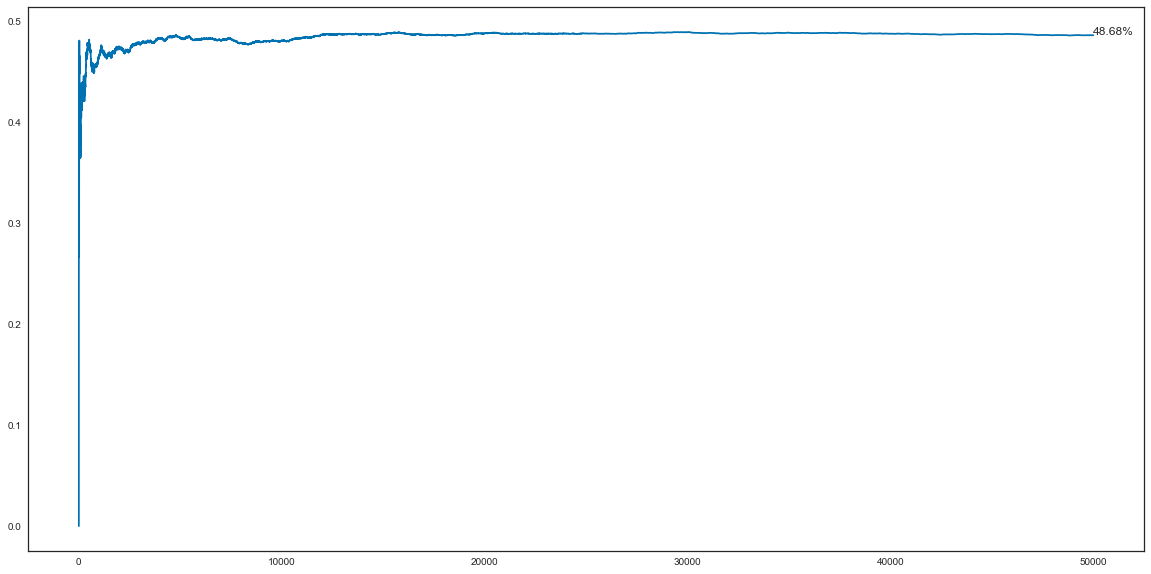

In [25]:
def play_basic(tables=1000):
    ''' Probability to double deposit using basic best strategy '''
    basic = Basic(deposit=10)
    param = {
        's17': True                # whether the dealer hits on a soft 17 
        , 'natural_pay':1.5        # payout for natural blackjack
        , 'surrender': True        # whether surrender is allowed
        , 'early_surrender': True  # whether surrender is allowed against dealer natural blackjack
        , 'split': None            # number of split and resplit allowed. None unlimitted resplit
        , 'double': True           # whether double down is allowed 
        , 'split_double': True     # whether doubling down is allowed after a split
        }
    results=[]
    for _ in range(tables):
        basic.balance=10
        basic.seats=1   
        table = Table(players=[basic], shoe=Shoe(8), **param).simulate()
        results.append(bool(basic))
    return results

# plot the cumulative probability of double winnings
res = play_basic(50000)
cum = [sum(res[:i])/i for i in range(1,len(res))]
matplotlib.pyplot.plot(range(1, len(res)), cum)
matplotlib.pyplot.text(len(res), sum(res)/len(res), '{:.2%}'.format(sum(res)/len(res)));

** Summary ** 
* A player will still lose on the long run when using a basic strategy
* House edge are around 1.5% for this set of rules
* Basic strategy can be further optimise adding a bet size change strategy

Reinforcement Learning for Basic Blackjack Startegy
----------------------------------------------------------------------------------------------

Simple reinforcement learning is based on Markov decision processes with an agent taking actions in an environement. The result of the action taken by the agent is interpreted as a reward, feeding back future decision on the environment. Initially and with no prior knowledge, an agent will choose an action randomly to explore the possible outcomes and rewards of the available actions (exploration) until decision is choosed for the best possible outcome (exploitation)

A greedy approach of reinforcement learning is implemented via the player *Learner* with the result of an action (stand, hit, split, double down or surrender) interpreted by the final winning of a hand. Below is a simulation to determine basic blackjack startegy using *Learner*

In [26]:
def play_learner(tables=1000):
    ''' Determine basic strategy using a Learner '''
    learner = Learner(deposit=100, rate=1000, bet=1)
    param = {
        's17': True                # whether the dealer hits on a soft 17 
        , 'natural_pay':1.5        # payout for natural blackjack
        , 'surrender': True        # whether surrender is allowed
        , 'early_surrender': True  # whether surrender is allowed against dealer natural blackjack
        , 'split': None            # number of split and resplit allowed. None unlimitted resplit
        , 'double': True           # whether double down is allowed 
        , 'split_double': True     # whether doubling down is allowed after a split
        }
    for _ in range(tables):
        learner.balance=100
        learner.seats=1   
        table = Table(players=[learner], shoe=Shoe(8), **param).simulate()
    return learner

learner = play_learner(10000)
dfs = learner.dataframe_best_actions()

In [27]:
# hard hand strategy 
dfs[0]

2                 3                 4                 5  \
20        stand_hand        stand_hand        stand_hand        stand_hand   
19        stand_hand        stand_hand        stand_hand        stand_hand   
18        stand_hand        stand_hand        stand_hand        stand_hand   
17        stand_hand        stand_hand        stand_hand        stand_hand   
16        stand_hand        stand_hand        stand_hand        stand_hand   
15        stand_hand        stand_hand        stand_hand        stand_hand   
14        stand_hand        stand_hand        stand_hand        stand_hand   
13        stand_hand        stand_hand        stand_hand        stand_hand   
12          hit_hand        stand_hand        stand_hand        stand_hand   
11  double_down_hand  double_down_hand  double_down_hand  double_down_hand   
10  double_down_hand  double_down_hand  double_down_hand  double_down_hand   
9   double_down_hand  double_down_hand  double_down_hand  double_down_hand   
8           hit_hand          hit_hand          hit_hand          hit_hand   
7           hit_hand          hit_hand          hit_hand          hit_hand   
6           hit_hand          hit_hand          hit_hand          hit_hand   
5           hit_hand          hit_hand          hit_hand          hit_hand   

                   6                 7                 8                 9  \
20        stand_hand        stand_hand        stand_hand        stand_hand   
19        stand_hand        stand_hand        stand_hand        stand_hand   
18        stand_hand        stand_hand        stand_hand        stand_hand   
17        stand_hand        stand_hand        stand_hand        stand_hand   
16        stand_hand          hit_hand    surrender_hand    surrender_hand   
15        stand_hand          hit_hand          hit_hand    surrender_hand   
14        stand_hand          hit_hand          hit_hand          hit_hand   
13        stand_hand          hit_hand          hit_hand          hit_hand   
12        stand_hand          hit_hand          hit_hand          hit_hand   
11  double_down_hand  double_down_hand  double_down_hand  double_down_hand   
10  double_down_hand  double_down_hand  double_down_hand  double_down_hand   
9   double_down_hand  double_down_hand  double_down_hand          hit_hand   
8   double_down_hand          hit_hand          hit_hand          hit_hand   
7           hit_hand          hit_hand          hit_hand          hit_hand   
6           hit_hand          hit_hand          hit_hand          hit_hand   
5           hit_hand          hit_hand          hit_hand          hit_hand   

                10         (1, 11)  
20      stand_hand      stand_hand  
19      stand_hand      stand_hand  
18      stand_hand  surrender_hand  
17      stand_hand  surrender_hand  
16  surrender_hand  surrender_hand  
15  surrender_hand  surrender_hand  
14  surrender_hand  surrender_hand  
13  surrender_hand  surrender_hand  
12        hit_hand  surrender_hand  
11        hit_hand        hit_hand  
10        hit_hand        hit_hand  
9         hit_hand        hit_hand  
8         hit_hand        hit_hand  
7         hit_hand        hit_hand  
6         hit_hand        hit_hand  
5         hit_hand        hit_hand

In [28]:
# soft hand strategy 
dfs[1]

2                 3                 4  \
(10, 20)        stand_hand        stand_hand        stand_hand   
(9, 19)         stand_hand        stand_hand        stand_hand   
(8, 18)   double_down_hand  double_down_hand  double_down_hand   
(7, 17)   double_down_hand  double_down_hand  double_down_hand   
(6, 16)   double_down_hand  double_down_hand  double_down_hand   
(5, 15)   double_down_hand          hit_hand  double_down_hand   
(4, 14)           hit_hand          hit_hand  double_down_hand   
(3, 13)   double_down_hand          hit_hand          hit_hand   

                         5                 6                 7           8  \
(10, 20)        stand_hand        stand_hand        stand_hand  stand_hand   
(9, 19)         stand_hand        stand_hand        stand_hand  stand_hand   
(8, 18)   double_down_hand  double_down_hand        stand_hand  stand_hand   
(7, 17)   double_down_hand  double_down_hand  double_down_hand    hit_hand   
(6, 16)   double_down_hand  double_down_hand          hit_hand    hit_hand   
(5, 15)   double_down_hand  double_down_hand          hit_hand    hit_hand   
(4, 14)   double_down_hand  double_down_hand          hit_hand    hit_hand   
(3, 13)   double_down_hand  double_down_hand          hit_hand    hit_hand   

                   9          10     (1, 11)  
(10, 20)  stand_hand  stand_hand  stand_hand  
(9, 19)   stand_hand  stand_hand  stand_hand  
(8, 18)     hit_hand  stand_hand    hit_hand  
(7, 17)     hit_hand    hit_hand    hit_hand  
(6, 16)     hit_hand    hit_hand    hit_hand  
(5, 15)     hit_hand    hit_hand    hit_hand  
(4, 14)     hit_hand    hit_hand    hit_hand  
(3, 13)     hit_hand    hit_hand    hit_hand

In [29]:
# pair strategy 
dfs[2]

2                 3                 4  \
(2, 12)        split_hand        split_hand        split_hand   
20             stand_hand        stand_hand        stand_hand   
18             stand_hand        stand_hand        stand_hand   
16             split_hand        split_hand        split_hand   
14             split_hand        split_hand        split_hand   
12             split_hand        split_hand        split_hand   
10       double_down_hand  double_down_hand  double_down_hand   
8                hit_hand          hit_hand          hit_hand   
6                hit_hand          hit_hand        split_hand   
4                hit_hand        split_hand        split_hand   

                        5                 6                 7  \
(2, 12)        split_hand        split_hand        split_hand   
20             stand_hand        stand_hand        stand_hand   
18             stand_hand        stand_hand        stand_hand   
16             split_hand        split_hand        split_hand   
14             split_hand        split_hand        split_hand   
12             split_hand        split_hand        split_hand   
10       double_down_hand  double_down_hand  double_down_hand   
8              split_hand        split_hand          hit_hand   
6              split_hand        split_hand        split_hand   
4                hit_hand        split_hand        split_hand   

                        8                 9          10     (1, 11)  
(2, 12)        split_hand        split_hand  split_hand  split_hand  
20             stand_hand        stand_hand  stand_hand  stand_hand  
18             stand_hand        split_hand  split_hand  split_hand  
16             split_hand        split_hand  split_hand  split_hand  
14             split_hand        split_hand  split_hand  split_hand  
12             split_hand        split_hand  split_hand  split_hand  
10       double_down_hand  double_down_hand    hit_hand    hit_hand  
8                hit_hand          hit_hand  split_hand  split_hand  
6              split_hand        split_hand  split_hand  split_hand  
4              split_hand        split_hand  split_hand  split_hand

Although not exactly the exact basic strategy, a simple learner is able to capture most of the Basic player actions given a state (hand and dealer exposed card) without any tuning

However one of the most important challenge in reinforcement learning is to decide when to make the learner move from exploration to exploitation

Rate in the implementation can be interpreted as the number of times a state (hand and dealer exposed card) is to be played randomly before the most favorable outcome is played consistently

Below a simulation showing the importance of the larning rate in reinforcement learning

In [13]:
players = [Basic(deposit=10, bet=1)]+[Learner(deposit=10, rate=10**n, bet=1) for n in range(5)]
results = {player: {'win': []} for player in players}
param = {
    's17': True                # whether the dealer hits on a soft 17 
    , 'natural_pay':1.5        # payout for natural blackjack
    , 'surrender': True        # whether surrender is allowed
    , 'early_surrender': True  # whether surrender is allowed against dealer natural blackjack
    , 'split': None            # number of split and resplit allowed. None unlimitted resplit
    , 'double': True           # whether double down is allowed 
    , 'split_double': True     # whether doubling down is allowed after a split
    }

In [14]:
def play_tables(results, tables=1000):
    for _ in range(tables):
        for each in players:
            each.balance=10
            each.seats=1 
        table = Table(players=players, shoe=Shoe(8), **param).simulate()
        for player in players:
            results[player]['win'].append(bool(player))
    return results 

In [77]:
res = play_tables(results, 1000000)

In [78]:
rates = []
for player in results:
    win = res[player]['win']
    res[player]['cum'] = numpy.cumsum(win)/range(1, len(win)+1)
    cum = res[player]['cum']
    label = 'Basic' if player.__class__.__name__=='Basic' else 'Learner '+str(player.rate)
    matplotlib.pyplot.plot(range(len(cum)), cum, label=label)
    rates.append('{:.4%}'.format(sum(win)/len(win)))
    matplotlib.pyplot.text(len(cum), sum(win)/len(win), '{:.2%}'.format(sum(win)/len(win)))
matplotlib.pyplot.legend(loc='upper center', ncol=3);
print(rates)

['48.7591%', '17.0354%', '38.2384%', '47.6136%', '47.8195%', '35.0709%']


** Summary **
* A simple reinforcement learving approach manages to learn the best strategy: both Learners 100 and 1000 success rates converge to almost the same level as Basic. Fine tuning in the algorythm would put Learner to the same level as Basic
* However a very fast Learner (moving from exploration to exploitation early) is likely to get stuck repeating the wrong decisions for a given state as success rates do not reach the same level as slower learners 
* On the other hand and after a total of almost 2 million table simulation, a very slow learner (moving from exploration to exploitation late) has not yet reach the level of success of one of the slowest learner